In [1]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf #야휴 finance에서 가져옴

from sklearn.preprocessing import MinMaxScaler

from glob import glob
from tensorflow import keras
import statsmodels.api as sm #통계 패키지
from matplotlib import pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Masking, Flatten, Embedding, Dense, LSTM, Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import math

In [3]:
df = yf.download('AMZN',
                  start = '2015-01-01',
                  end = '2023-12-31',
                  progress = False)

In [4]:
df.head() # Multi-index가 있네요...

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2015-01-02,15.4260,15.7375,15.3480,15.6290,55664000
2015-01-05,15.1095,15.4190,15.0425,15.3505,55484000
2015-01-06,14.7645,15.1500,14.6190,15.1120,70380000
2015-01-07,14.9210,15.0640,14.7665,14.8750,52806000
2015-01-08,15.0230,15.1570,14.8055,15.0160,61768000


In [5]:
df.columns

MultiIndex([( 'Close', 'AMZN'),
            (  'High', 'AMZN'),
            (   'Low', 'AMZN'),
            (  'Open', 'AMZN'),
            ('Volume', 'AMZN')],
           names=['Price', 'Ticker'])

In [6]:
## Multi-Index 제거
df.columns = [x[0] for x in df.columns]
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [7]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,15.426000,15.737500,15.348000,15.629000,55664000
2015-01-05,15.109500,15.419000,15.042500,15.350500,55484000
2015-01-06,14.764500,15.150000,14.619000,15.112000,70380000
2015-01-07,14.921000,15.064000,14.766500,14.875000,52806000
2015-01-08,15.023000,15.157000,14.805500,15.016000,61768000
...,...,...,...,...,...
2023-12-22,153.419998,154.350006,152.710007,153.770004,29480100
2023-12-26,153.410004,153.979996,153.029999,153.559998,25067200
2023-12-27,153.339996,154.779999,153.119995,153.559998,31434700


In [8]:
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2264 non-null   float64
 1   High    2264 non-null   float64
 2   Low     2264 non-null   float64
 3   Open    2264 non-null   float64
 4   Volume  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1 KB


In [9]:
# 비어있는 날짜를 forward fill로 imputation
df_n = pd.DataFrame()
for i in range(len(df.columns)):
  df_n[df.columns[i]] = df[df.columns[i]].resample('1d').mean().ffill()

In [10]:
df_n

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,15.426000,15.737500,15.348000,15.629000,55664000.0
2015-01-03,15.426000,15.737500,15.348000,15.629000,55664000.0
2015-01-04,15.426000,15.737500,15.348000,15.629000,55664000.0
2015-01-05,15.109500,15.419000,15.042500,15.350500,55484000.0
2015-01-06,14.764500,15.150000,14.619000,15.112000,70380000.0
...,...,...,...,...,...
2023-12-25,153.419998,154.350006,152.710007,153.770004,29480100.0
2023-12-26,153.410004,153.979996,153.029999,153.559998,25067200.0
2023-12-27,153.339996,154.779999,153.119995,153.559998,31434700.0


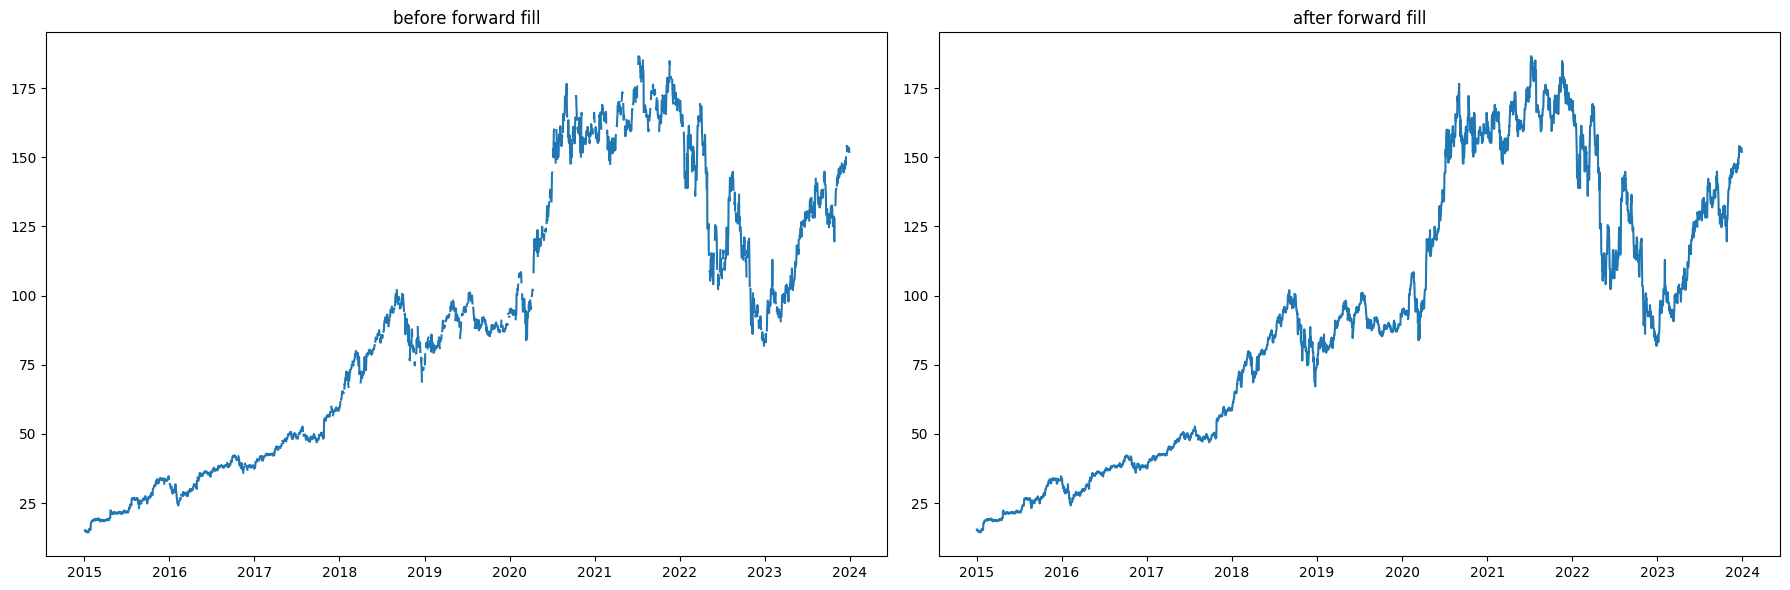

In [11]:
# 비어있는 데이터를 채워준거 확인 가능

a = df['Close'].resample('1d').mean()
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(a)
plt.title('before forward fill')
plt.subplot(122)
plt.plot(df_n['Close'])
plt.title('after forward fill')
plt.tight_layout()
plt.show()

In [12]:
# 1020개의 결측치
a.isnull().sum()

1020

In [13]:
# 모든 것에서의 결측치가 빠진 걸 볼 수 있음
df.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


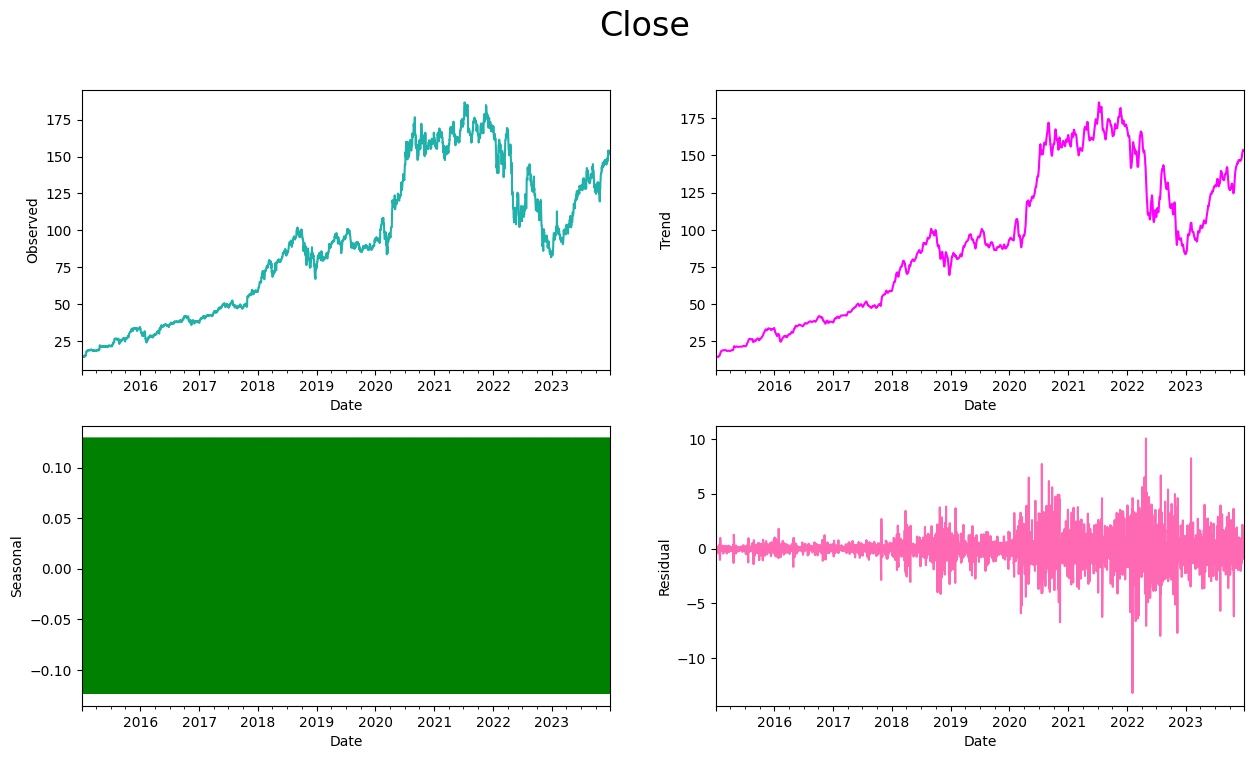

In [14]:
col_list = ['lightseagreen','magenta','blue','green','hotpink']

seasonal_decom = sm.tsa.seasonal_decompose(df_n['Close'],model='additive')

fig, axes = plt.subplots(2,2, figsize=(15,8))
seasonal_decom.observed.plot(legend = False, ax=axes[0][0],color=col_list[0])
axes[0][0].set_ylabel('Observed')
seasonal_decom.trend.plot(legend = False, ax=axes[0][1],color=col_list[1])
axes[0][1].set_ylabel('Trend')
seasonal_decom.seasonal.plot(legend = False, ax=axes[1][0],color=col_list[3])
axes[1][0].set_ylabel('Seasonal')
seasonal_decom.resid.plot(legend = False, ax=axes[1][1],color=col_list[4])
axes[1][1].set_ylabel('Residual')
plt.suptitle('{}'.format('Close'),fontsize = 24)
plt.show()

In [15]:
seasonal_decom.seasonal

,seasonal
Date,
2015-01-02,-0.038310
2015-01-03,-0.080631
2015-01-04,-0.122884
2015-01-05,-0.062124
2015-01-06,0.051821
...,...
2023-12-25,-0.062124
2023-12-26,0.051821
2023-12-27,0.128750


In [16]:
## vital sign visualization
col_list = ['orangered','deepskyblue','chartreuse','olive']
sub_idx = [[1,1],[1,2],[2,1],[2,2]]

fig_graph_vit_par = make_subplots(rows=2, cols=2,
                                  subplot_titles=('Close', 'High', 'Low', 'Open'
                                                  ))

for i in range(4):
  fig_graph_vit_par.add_trace(go.Scatter(x=df.index, y=df[df.columns[i]],
                                          mode='lines+markers',
                                          name=df.columns[i],
                                          line=dict(color=col_list[i], width=2),
                                          connectgaps=True, ),row=sub_idx[i][0], col=sub_idx[i][1],)

  fig_graph_vit_par.add_vrect(
      x0='2023-01-01',
      x1='2023-12-28',
      fillcolor="LightSalmon", opacity=0.5,
      layer="below", line_width=0,
  )


fig_graph_vit_par.update_layout(
    autosize=False,
    width=1600,
    height=1200,
    title_text="Close_mean: {:.3f}\nHigh_mean: {:.3f}\nLow_mean: {:.3f}\nOpen_mean: {:.3f}".format(df[df.columns[0]].mean(),
                                                                                                   df[df.columns[1]].mean(),
                                                                                                   df[df.columns[2]].mean(),
                                                                                                   df[df.columns[3]].mean())
                                                                                  )

fig_graph_vit_par.show()

# Data Split

In [17]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input:
        data: dataframe with dates and price data
    output:
        X_train, y_train: data from 2015/1/1-2022/12/31
        X_test : data from 2023-
        sc :     insantiated MinMaxScaler object fit to the training data
    """
    # create training and test set
    ts_train = all_data[:'2022'].iloc[:,0:1].values
    ts_test = all_data['2023':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))

    inputs = pd.concat((all_data["Close"][:'2022'], all_data["Close"]['2023':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train , X_test, sc


In [18]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df_n, 6,1)
X_train.shape

(2914, 6, 1)

In [19]:
# sequence 순서대로 x,y 값 확인
a = pd.DataFrame(X_train[:,:,0])
a['y'] = y_train
a.head()

,0,1,2,3,4,5,y
0,0.006262,0.006262,0.006262,0.004424,0.002421,0.003330,0.003922
1,0.006262,0.006262,0.004424,0.002421,0.003330,0.003922,0.002897
2,0.006262,0.004424,0.002421,0.003330,0.003922,0.002897,0.002897
3,0.004424,0.002421,0.003330,0.003922,0.002897,0.002897,0.002897
4,0.002421,0.003330,0.003922,0.002897,0.002897,0.002897,0.001295


In [20]:
time_steps = 6
for_periods = 1

# create training and test set
ts_train = df_n[:'2022'].iloc[:,0:1].values
ts_test = df_n['2023':].iloc[:,0:1].values
ts_train_len = len(ts_train)
ts_test_len = len(ts_test)

ts_train.shape

(2921, 1)

In [21]:
# scale the data
sc = MinMaxScaler(feature_range=(0,1))
ts_train_scaled = sc.fit_transform(ts_train)

print(ts_train.max(), ts_train_scaled.max())

# create training data of s samples and t time steps
X_train = []
y_train = []
for i in range(time_steps, ts_train_len-1):
    X_train.append(ts_train_scaled[i-time_steps:i, 0])
    y_train.append(ts_train_scaled[i:i+for_periods, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape , y_train.shape)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))

print(X_train.shape , y_train.shape)

a = pd.DataFrame(X_train[:,:,0])
a['y'] = y_train
a.head()


186.57049560546875 1.0000000000000002
(2914, 6) (2914, 1)
(2914, 6, 1) (2914, 1)


,0,1,2,3,4,5,y
0,0.006262,0.006262,0.006262,0.004424,0.002421,0.003330,0.003922
1,0.006262,0.006262,0.004424,0.002421,0.003330,0.003922,0.002897
2,0.006262,0.004424,0.002421,0.003330,0.003922,0.002897,0.002897
3,0.004424,0.002421,0.003330,0.003922,0.002897,0.002897,0.002897
4,0.002421,0.003330,0.003922,0.002897,0.002897,0.002897,0.001295


In [22]:
inputs = pd.concat((df_n["Close"][:'2022'], df_n["Close"]['2023':]), axis=0).values
print(inputs.shape)
inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
# Preparing X_test
X_test = []
for i in range(time_steps, ts_test_len + time_steps - for_periods):
    X_test.append(inputs[i-time_steps:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(3284,)
(369,)
(369, 1)
(362, 6, 1)


In [23]:
pd.DataFrame(X_test[:10,:,0])

,0,1,2,3,4,5
0,0.411690,0.398858,0.391774,0.405477,0.404432,0.404432
1,0.398858,0.391774,0.405477,0.404432,0.404432,0.404432
2,0.391774,0.405477,0.404432,0.404432,0.404432,0.404432
3,0.405477,0.404432,0.404432,0.404432,0.404432,0.415000
4,0.404432,0.404432,0.404432,0.404432,0.415000,0.411051
5,0.404432,0.404432,0.404432,0.415000,0.411051,0.399322
6,0.404432,0.404432,0.415000,0.411051,0.399322,0.416509
7,0.404432,0.415000,0.411051,0.399322,0.416509,0.416509
8,0.415000,0.411051,0.399322,0.416509,0.416509,0.416509
9,0.411051,0.399322,0.416509,0.416509,0.416509,0.423942


# LSTM, GRU 학습

In [24]:

def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD

    # The LSTM architecture
    my_LSTM_model = Sequential()
    # input_layer = Input(shape=(time_steps, 1))
    my_LSTM_model.add(LSTM(units = 50,
                           return_sequences = True,
                           input_shape = (X_train.shape[1],1),
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))


    # Compiling
    SGD = optimizers.SGD(learning_rate=0.01, weight_decay=1e-7)
    my_LSTM_model.compile(optimizer=SGD, loss='mean_squared_error', metrics=['mean_squared_error'])

    # Fitting to the training set
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [25]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Close', 'prediction'])
    actual_pred['Close'] = df_n.loc['2023':,'Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,704 (119.94 KB)

 Trainable params: 30,702 (119.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


(167.95915, <Axes: xlabel='Date'>)

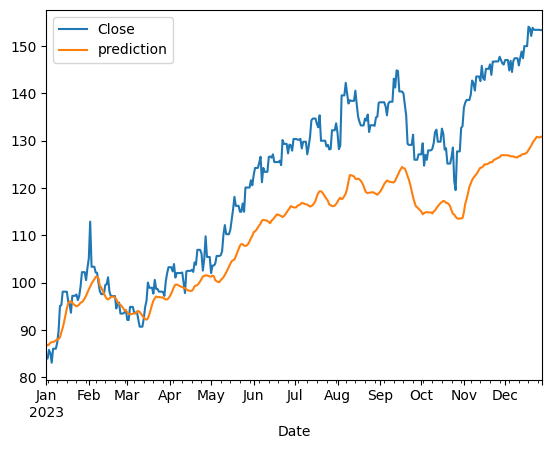

In [26]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
print(my_LSTM_model.summary())
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [27]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test=df_n.loc['2023':,'Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)

    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [29]:
confirm_result(y_test, y_pred)

,Results
MAE,10.90170
RMSE,12.95991
RMSLE,0.10077
R2,0.52966


In [30]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD

    # The GRU architecture
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50,
                         return_sequences = True,
                         input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50,
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))

    # Compiling
    SGD = optimizers.SGD(learning_rate=0.01, weight_decay=1e-7)
    my_GRU_model.compile(optimizer=SGD, loss='mean_squared_error', metrics=['mean_squared_error'])

    # Fitting to the trainig set
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 6, 50)               │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,354 (91.23 KB)

 Trainable params: 23,352 (91.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


(6.8541255, <Axes: xlabel='Date'>)

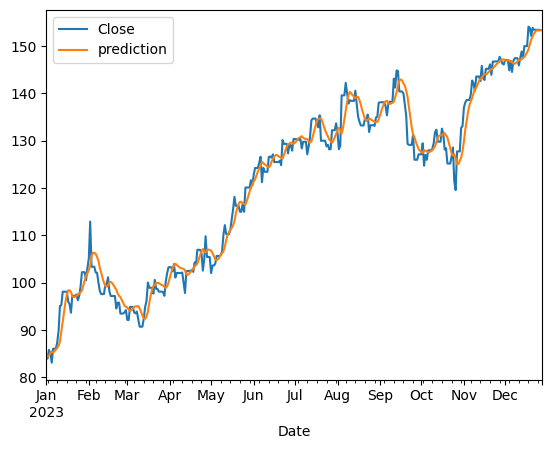

In [31]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
print(my_GRU_model.summary())
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [32]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=df_n.loc['2023':,'Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [33]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,1.99904
RMSE,2.61804
RMSLE,0.02221
R2,0.98081


In [34]:
a = confirm_result(y_test, y_pred)
aa = confirm_result(y_test_gru, y_pred_gru)

a['Results_GRU'] = aa
a

,Results,Results_GRU
MAE,10.90170,1.99904
RMSE,12.95991,2.61804
RMSLE,0.10077,0.02221
R2,0.52966,0.98081


In [35]:
true_train = np.array(ts_train)[:,0]
true_test = np.array(ts_test)[:-1,0]
pred_lstm = np.array(y_pred)[:,0]
pred_gru = np.array(y_pred_gru)[:,0]

In [36]:
print(len(df_n.index))
print(len(true_train) + len(true_test))
print(len(true_train) + len(pred_lstm))

3284
3283
3283


In [37]:
a = pd.DataFrame({'True':np.concatenate([true_train,true_test],axis=0),
                  'LSTM_Pred':np.concatenate([true_train,pred_lstm],axis=0),
                  'GRU_Pred':np.concatenate([true_train,pred_gru],axis=0)},index=df_n.index[:-1])

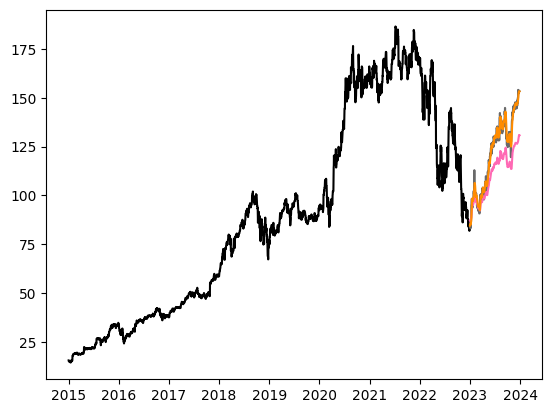

In [38]:
plt.plot(a[a.index<'2023-01-01']['LSTM_Pred'],color='black')
plt.plot(a[a.index>='2023-01-01']['True'],color='dimgrey')
plt.plot(a[a.index>='2023-01-01']['LSTM_Pred'],color='hotpink')
plt.plot(a[a.index>='2023-01-01']['GRU_Pred'],color='darkorange')